#### Συσταδοποίηση (Clustering)

In [55]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, rand_score, calinski_harabasz_score

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import KernelPCA, PCA

from sklearn.naive_bayes import GaussianNB

import seaborn as sns
from matplotlib import pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
# plt.style.use('dark_background')

In [56]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [57]:
data = pd.read_pickle('clean-bank-data.pickle')

In [58]:
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']
scaler = data['scaler']

In [110]:
X_train.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'month_apr', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object')

### Συσταδοποίηση με K-Means

#### Fit και διερεύνηση βέλτιστου αριθμού συστάδων

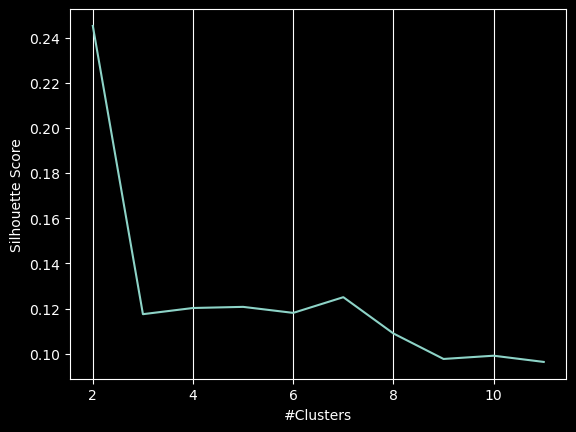

In [60]:
scores =[]
inertias =[]

for k in range(2,12):
    bank_kmeans = KMeans(n_clusters = k, n_init=10)
    scores.append(silhouette_score(X_train, bank_kmeans.fit_predict(X_train)))
    inertias.append(bank_kmeans.inertia_)

ax = pd.Series(scores, index=range(2,12)).plot()
ax.set_xlabel('#Clusters')
ax.set_ylabel('Silhouette Score')
ax.grid(axis = 'x', visible = True)

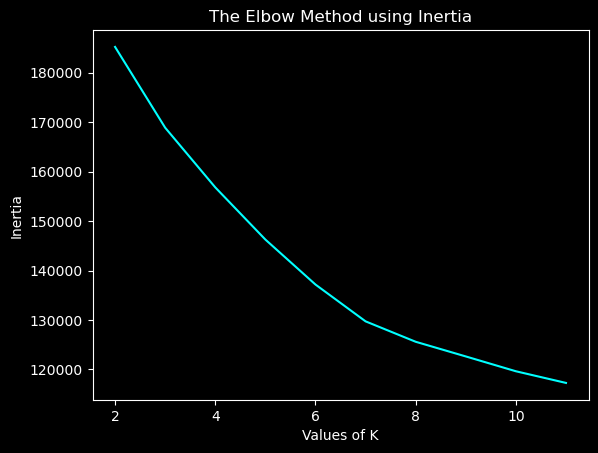

In [61]:
# ELBOW CRITERION
plt.plot(range(2,12), inertias, 'cyan')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

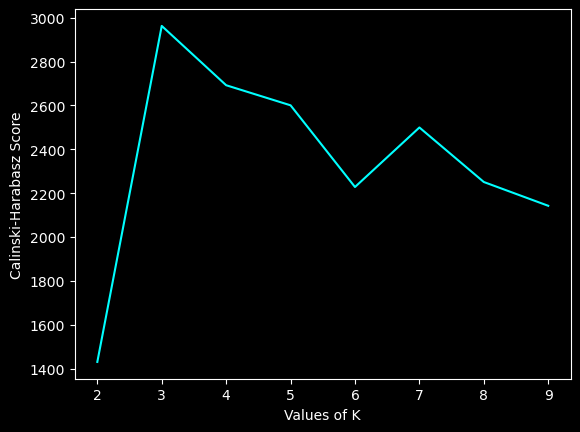

In [62]:
# Calinski-Harabasz Score
ch_scores = []
K = range(2, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    ch_scores.append(calinski_harabasz_score(X_train, kmeanModel.predict(X_train)),)
    
plt.plot(K, ch_scores, 'cyan')
plt.xlabel('Values of K')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

Η υψηλότερη τιμή CH αντιστοιχεί στο σύνολο συστάδων που είναι πιο πυκνά και πιο απομακρυσμένα. 
(Δυστυχώς η υψηλότερη τιμή φαίνεται να είναι κοντά στο 1 που πιθανόν είναι ενδεικτικό πως το σύνολο δεδομένων με το οποίο δουλεύω δεν μάλλον κατάλληλο για συσταδοποίηση στην συνολική μορφή του)

In [63]:
bank_kmeans = KMeans(n_clusters=6, n_init=10).fit(X_train)

In [64]:
bank_kmeans

KMeans(n_clusters=6, n_init=10)

### Οπτικοποίηση αποτελεσμάτων

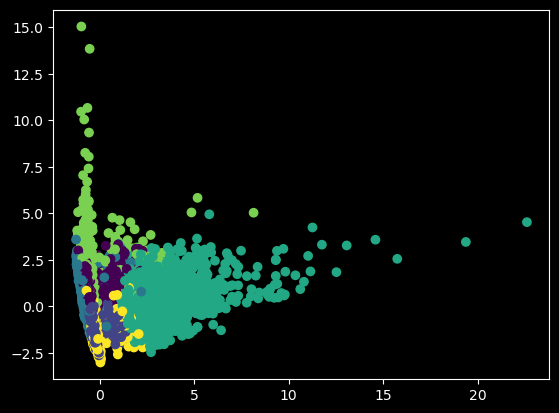

In [65]:
pca = PCA(n_components=2)
X_train_2D=pca.fit_transform(X_train)
plt.scatter(*X_train_2D.T, c=bank_kmeans.predict(X_train))

In [66]:
pca = KernelPCA(kernel='cosine', n_components=2, n_jobs=-1)
X_train_2D=pca.fit_transform(X_train)

In [67]:
X_train_2D.T

array([[ 0.29046342, -0.19573194, -0.34476153, ..., -0.03808524,
         0.03043213,  0.08041317],
       [-0.26412894,  0.22320608,  0.46000404, ..., -0.19977028,
        -0.21105042,  0.14353583]])

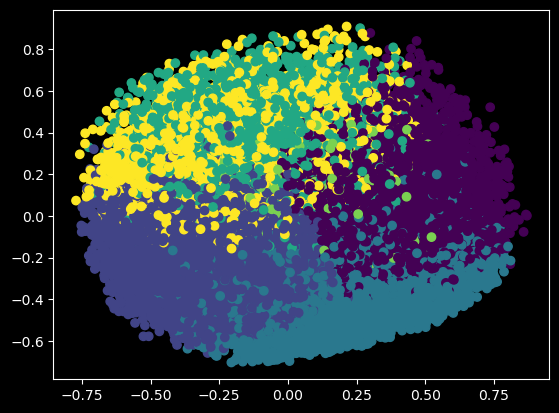

In [68]:
plt.scatter(*X_train_2D.T, c=bank_kmeans.predict(X_train))

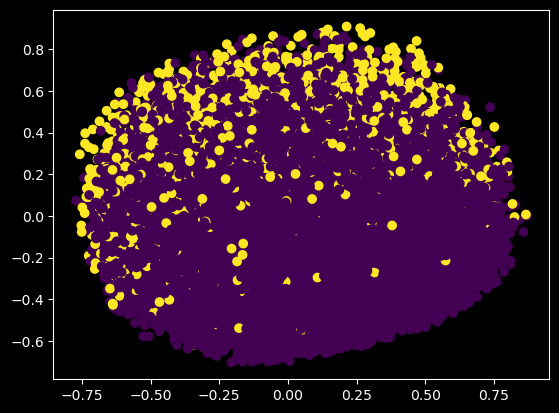

In [69]:
plt.scatter(*X_train_2D.T, c=LabelEncoder().fit_transform(y_train))

### Ανάλυση Συσταδοποίησης

In [70]:
rand_score(LabelEncoder().fit_transform(y_train), bank_kmeans.predict(X_train))

np.float64(0.31509969216032807)

In [71]:
rand_score(LabelEncoder().fit_transform(y_test), bank_kmeans.predict(X_test))

np.float64(0.31805770232130937)

#### Κανόνες Συσχέτισης

In [72]:
bank_kmeans_labels = pd.Series(bank_kmeans.predict(X_train), index=X_train.index)

In [73]:
bank_kmeans_labels

13742    2
12154    5
23911    3
33502    3
24890    1
        ..
5623     1
15363    5
14670    2
5921     1
32645    0
Length: 23199, dtype: int32

In [74]:
# Assuming 'cid' is the cluster id we want to work with
cid = 0

# Extract the rows where the cluster label matches cid
X_train_cid = X_train.loc[bank_kmeans_labels == cid].copy()

In [75]:
X_train_cid.describe()

,age,balance,duration,campaign,pdays,previous
count,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000,5251.000000
mean,1.144747,-0.042757,-0.338211,-0.372622,-0.337519,-0.237478
std,0.599419,0.568678,0.638152,0.545275,0.340363,0.303650
min,-0.150944,-1.329671,-1.471373,-0.857090,-0.424315,-0.308772
25%,0.647106,-0.414128,-0.833928,-0.857090,-0.424315,-0.308772
50%,1.145887,-0.267601,-0.447164,-0.102436,-0.424315,-0.308772
75%,1.544912,0.112318,0.054198,-0.102436,-0.424315,-0.308772
max,2.941500,2.482635,2.102617,1.406872,2.309370,3.833608


In [76]:
numeric_col = X_train_cid.select_dtypes(include='number').columns
numeric_col

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

#### Αντιστροφή της Κλιμάκωσης των αριθμητικών χαρακτηριστικών

In [77]:
X_train_cid[numeric_col] = scaler.inverse_transform(X_train_cid[numeric_col])

In [78]:
X_train_cid.describe()

,age,balance,duration,campaign,pdays,previous
count,5251.000000,5251.000000,5251.000000,5251.000000,5251.00000,5251.000000
mean,51.988574,1213.920015,160.211960,1.641973,7.92192,0.137688
std,6.008840,1734.836501,89.098729,0.722550,34.98649,0.586426
min,39.000000,-2712.000000,2.000000,1.000000,-1.00000,0.000000
25%,47.000000,81.000000,91.000000,1.000000,-1.00000,0.000000
50%,52.000000,528.000000,145.000000,2.000000,-1.00000,0.000000
75%,56.000000,1687.000000,215.000000,2.000000,-1.00000,0.000000
max,70.000000,8918.000000,501.000000,4.000000,280.00000,8.000000


#### Οι κανόνες συσχέτισης λειτουργούν με κατηγορικά δεδομένα, οπότε τα αριθμητικά χαρακτηριστικά θα διακριτοποιηθούν

In [79]:

X_train_cid['age'] = pd.cut(X_train_cid['age'], bins=5, include_lowest=True)
X_train_cid['balance'] = pd.cut(X_train_cid['balance'], bins=10, include_lowest=True)
X_train_cid['duration'] = pd.cut(X_train_cid['duration'], bins=10, include_lowest=True)
X_train_cid['campaign'] = pd.cut(X_train_cid['campaign'], bins=4, include_lowest=True)
X_train_cid['pdays'] = pd.cut(X_train_cid['pdays'], bins=12, include_lowest=True)
X_train_cid['previous'] = pd.cut(X_train_cid['previous'], bins=12, include_lowest=True)


In [80]:
# Generate frequent itemsets using Apriori
freq_items = apriori(
    pd.get_dummies(X_train_cid).astype(bool),  # Convert categorical data to binary (one-hot encoding)
    min_support=0.4,
    use_colnames=True,
    max_len=None,
    verbose=0
)

# Generate association rules from the frequent itemsets
asc_rules = association_rules(
    freq_items, metric='confidence', min_threshold=0.8
)


In [81]:
asc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(housing),"(pdays_(-1.2819999999999998, 22.417])",0.430585,0.931632,0.408875,0.949580,1.019265,0.007728,1.355964,0.033193
1,(housing),"(previous_(-0.009000000000000001, 0.667])",0.430585,0.927633,0.407732,0.946926,1.020798,0.008307,1.363518,0.035782
2,(marital_married),"(pdays_(-1.2819999999999998, 22.417])",0.772615,0.931632,0.718530,0.929998,0.998246,-0.001263,0.976650,-0.007670
3,(marital_married),"(previous_(-0.009000000000000001, 0.667])",0.772615,0.927633,0.715673,0.926300,0.998563,-0.001030,0.981918,-0.006287
4,(education_secondary),"(pdays_(-1.2819999999999998, 22.417])",0.508094,0.931632,0.473624,0.932159,1.000566,0.000268,1.007766,0.001149
5,(education_secondary),"(previous_(-0.009000000000000001, 0.667])",0.508094,0.927633,0.470958,0.926912,0.999222,-0.000366,0.990131,-0.001579
6,"(balance_(-386.0, 777.0])","(pdays_(-1.2819999999999998, 22.417])",0.558751,0.931632,0.532089,0.952284,1.022167,0.011539,1.432796,0.049147
7,"(balance_(-386.0, 777.0])","(previous_(-0.009000000000000001, 0.667])",0.558751,0.927633,0.528852,0.946489,1.020328,0.010536,1.352390,0.045151
8,"(campaign_(0.996, 1.75])","(pdays_(-1.2819999999999998, 22.417])",0.497429,0.931632,0.453057,0.910796,0.977635,-0.010364,0.766425,-0.043537
9,"(campaign_(0.996, 1.75])","(previous_(-0.009000000000000001, 0.667])",0.497429,0.927633,0.451152,0.906968,0.977723,-0.010279,0.777873,-0.043370


### Συσταδοποίηση με DBSCAN

In [82]:
dbscan = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1)
dbscan.fit(X_train, y=y_train)

DBSCAN(eps=0.3, min_samples=10, n_jobs=-1)

In [83]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [84]:
# Identify Noise
n_noise = list(dbscan.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

Estimated no. of noise points: 23029


In [85]:
dbscan.core_sample_indices_, dbscan.core_sample_indices_.shape


(array([   13,   368,   785,   804,   847,   896,  1051,  1904,  2335,
         2780,  3110,  3977,  4603,  5115,  5151,  5950,  6024,  7139,
         7735,  8013,  9047,  9850,  9986, 10218, 10278, 10284, 10512,
        10546, 10593, 10720, 10818, 10962, 11380, 12078, 12453, 12819,
        12986, 13587, 13711, 14127, 14201, 14548, 14601, 15287, 15317,
        15361, 15429, 15543, 15621, 15987, 16490, 17175, 17518, 17795,
        17837, 18945, 19007, 19802, 19973, 19999, 20018, 20446, 21344,
        21816, 22412, 22587, 22779]),
 (67,))

In [86]:
np.where(dbscan.labels_ == -1), np.where(dbscan.labels_ == -1)[0].shape

((array([    0,     1,     2, ..., 23196, 23197, 23198]),), (23029,))

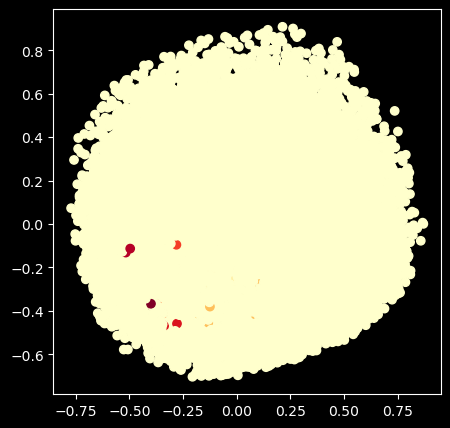

In [87]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=dbscan.labels_, cmap='YlOrRd')

In [88]:
# X_train_2D_df = pd.DataFrame(X_train_2D, columns=['X', 'Y'])
# sns.pairplot(X_train_2D_df, height=5)

#### Εκτίμηση βέλτιστων τιμών για τις παραμέτρους *esp* και *min_samples*

> Χρήση _NearestNeighbors_ για την εύρεση της βέλτιστης τιμής _esp_

In [89]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=20).fit(X_train)
distances, indices = nn.kneighbors(X_train)

Text(0, 0.5, 'Distance')

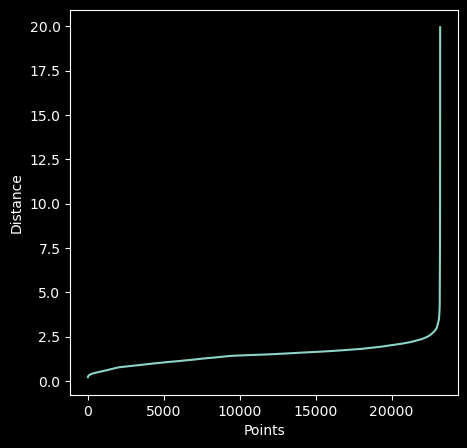

In [90]:
distances, indices = nn.kneighbors(X_train)
distances = np.sort(distances[:,10], axis=0)


fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

2.0998719301241855


<Figure size 400x400 with 0 Axes>

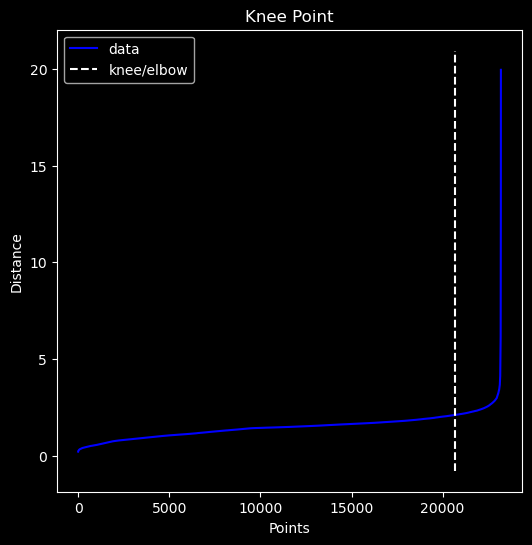

In [91]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(4, 4))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [92]:
total_elements = X_train.shape[0]*X_train.shape[1]
non_zero_elements = np.count_nonzero(X_train)
sparsity = 1 - (non_zero_elements / total_elements)

print(f"Sparsity of the dataset: {sparsity:.2%}")

Sparsity of the dataset: 71.74%


Το train_X είναι πολύ αραιό κυρίως λόγο όλων των κατηγορικών χρακτηριστικών που πέρασαν από *OneHot Encoding* και έχουν δημιουργήσει πολλές έξτρα στήλες με 0. Αυτό φαίνεται να δημιουργεί δυσκολία στον DBSCAN.

> Προσδιορισμός βέλτιστης τιμής *min_sample*

In [93]:
min_samples = 2*X_train.shape[1]
min_samples

76

In [94]:
min_samples = range(10,15)
eps = np.arange(0.3,1, 0.1)

output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(X_train).labels_
        score = silhouette_score(X_train, labels)
        output.append((ms, ep, score))

In [95]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: -0.2714586422369158
min_samples: 14
eps: 0.3


> **Η μόνη λύση που ο DBSCAN δίνει πάνω από μία συστάδα**
> - **Best silhouette_score:**  _-0.2714586422369158_
> - **min_samples:** _14_
> - **eps:** _0.3_


> Βέλτιστες τιμές που βρέθηκαν:
- **Best silhouette_score:**  _0.7532018163259846_
- **min_samples:** _15_
- **eps:** _3.5_
> Βέλτιστες τιμές που βρέθηκαν:
- **Best silhouette_score:**  _0.7406392813045335_
- **min_samples:** _21_
- **eps:** _3.5_
> Βέλτιστες τιμές που βρέθηκαν:
- **Best silhouette_score:**  _0.7245293472808821_
- **min_samples:** _30_
- **eps:** _3.5_

In [96]:
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(X_train)

labels = dbscan.labels_

# Number of clusters (ignore the noise/outliers, which are labeled as -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

n_outliers = np.sum(labels == -1)

# If there are clusters (more than one label that is not -1), calculate the silhouette score
if n_clusters > 1:
    silhouette = silhouette_score(X_train, labels)
else:
    silhouette = -1  # Silhouette score doesn't make sense with only one cluster

print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers}")
print(f"Silhouette Score: {silhouette}")

Number of clusters: 9
Number of outliers: 23029
Silhouette Score: -0.2997780424875075


In [97]:
from sklearn.preprocessing import OrdinalEncoder
oenc = OrdinalEncoder()

rand_score(oenc.fit_transform(y_train.values.reshape((-1,1))).flatten(), dbscan.labels_)

np.float64(0.8284094969607786)

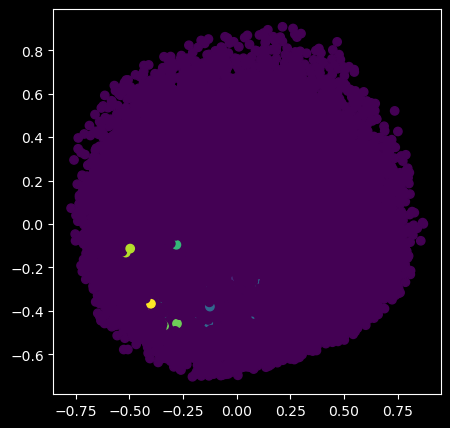

In [98]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=dbscan.labels_)

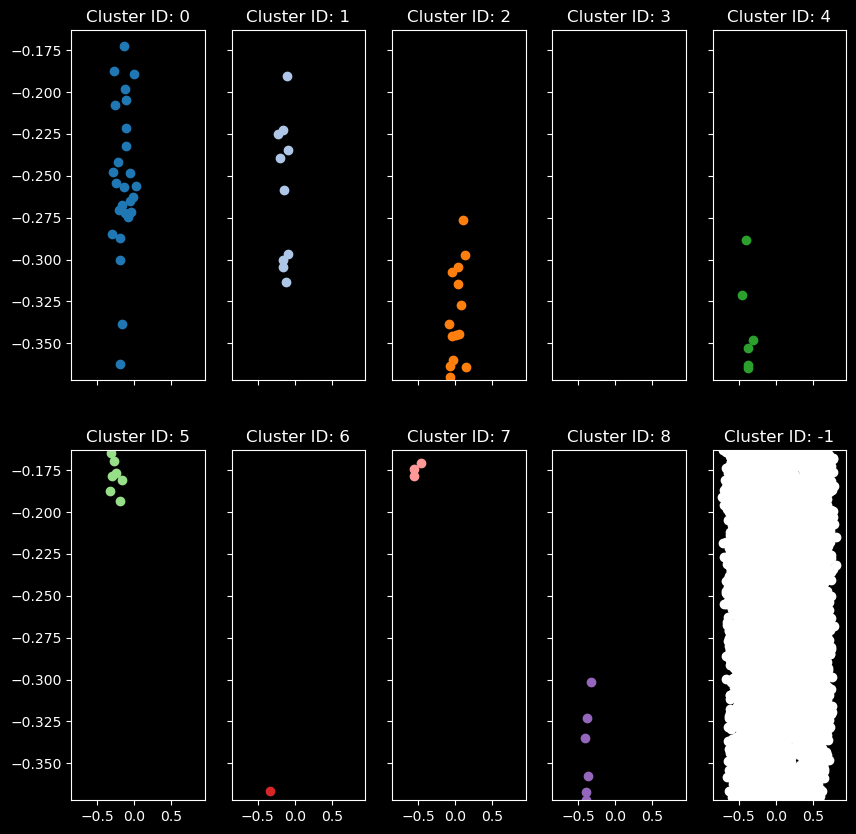

In [99]:
fig, ax = plt.subplots(2,5, figsize=(10, 10), sharex=True, sharey=True)
ax_flat = ax.flatten()

for i, cluster_id in enumerate(set(dbscan.labels_)):
    mask = dbscan.labels_ == cluster_id
    ax_flat[i].scatter(X_train_2D[mask, 0], X_train_2D[mask, 1], color=plt.cm.tab20(cluster_id) if cluster_id != -1 else 'white')
    ax_flat[i].set_title(f'Cluster ID: {cluster_id}')
    # ax_flat[i].set_xlim(-5, 15)
    ax_flat[i].set_ylim()


plt.style.use('dark_background')
plt.show()

In [102]:
labels

array([-1, -1, -1, ..., -1, -1, -1])

In [104]:
c0 = X_train[labels==0].copy()

In [106]:
c0[numeric_col] = scaler.inverse_transform(c0[numeric_col])

In [107]:
c0.describe()

,age,balance,duration,campaign,pdays,previous
count,26.000000,26.000000,26.000000,26.0,26.0,26.0
mean,34.653846,162.730769,156.230769,2.0,-1.0,0.0
std,2.481005,276.898473,25.895649,0.0,0.0,0.0
min,30.000000,-196.000000,104.000000,2.0,-1.0,0.0
25%,33.000000,0.500000,137.500000,2.0,-1.0,0.0
50%,35.000000,42.500000,155.500000,2.0,-1.0,0.0
75%,36.000000,317.000000,173.750000,2.0,-1.0,0.0
max,39.000000,705.000000,208.000000,2.0,-1.0,0.0


In [108]:
c0['age'] = pd.cut(c0['age'], bins=5, include_lowest=True)
c0['balance'] = pd.cut(c0['balance'], bins=10, include_lowest=True)
c0['duration'] = pd.cut(c0['duration'], bins=10, include_lowest=True)
c0['campaign'] = pd.cut(c0['campaign'], bins=4, include_lowest=True)
c0['pdays'] = pd.cut(c0['pdays'], bins=12, include_lowest=True)
c0['previous'] = pd.cut(c0['previous'], bins=12, include_lowest=True)

In [109]:
# Generate frequent itemsets using Apriori
freq_items = apriori(
    pd.get_dummies(c0).astype(bool),  # Convert categorical data to binary (one-hot encoding)
    min_support=0.4,
    use_colnames=True,
    max_len=None,
    verbose=0
)

# Generate association rules from the frequent itemsets
asc_rules = association_rules(
    freq_items, metric='confidence', min_threshold=0.8
)
asc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(job_blue-collar),(housing),1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
1,(housing),(job_blue-collar),1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
2,(housing),(marital_married),1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
3,(marital_married),(housing),1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
4,(education_secondary),(housing),1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
...,...,...,...,...,...,...,...,...,...,...
6045,"(pdays_(-1.0002, -1.0])","(previous_(-0.000167, 0.0], campaign_(1.999, 2...",1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
6046,(job_blue-collar),"(previous_(-0.000167, 0.0], campaign_(1.999, 2...",1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
6047,(marital_married),"(previous_(-0.000167, 0.0], campaign_(1.999, 2...",1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
6048,(housing),"(previous_(-0.000167, 0.0], campaign_(1.999, 2...",1.0,1.0,1.0,1.0,1.0,0.0,inf,0.0
